# Assignment — Tasks 1.1, 1.2 and 2.1 (Inline, CSV-only)

Este notebook contém:
- **Task 1.1**: preparação de dados, verificação de 258 vs 257, anomalias e colisões, trajetórias (plots inline);
- **Task 1.2**: baseline `StandardScaler → LinearRegression`, RMSE (train/val/test), y–ŷ (inline), submissão `baseline-model.csv`;
- **Task 2.1**: função `validate_poly_regression(...)`, testes por grau (1–14), `LinearRegression` e `RidgeCV`, gráfico RMSE vs grau + nº de features, 10 execuções e histograma do grau ótimo.

**Nota:** Os gráficos são mostrados **inline** (não se guardam imagens). Apenas são guardados **CSVs** de submissão.


In [23]:
# Imports & config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error
import seaborn as sns

%matplotlib inline

# Config
SEED = 123
TRAIN_PATH = '../data/X_train.csv'
TEST_PATH  = '../data/X_test.csv'

SPLIT_TRAIN = 0.70
SPLIT_VAL   = 0.15
SPLIT_TEST  = 0.15
assert abs(SPLIT_TRAIN + SPLIT_VAL + SPLIT_TEST - 1.0) < 1e-9

## Task 1.1 — Data Preparation & Validation (Inline Plots, CSV-only)

In [24]:
# Load data
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print('Train shape:', train.shape, '| Test shape:', test.shape)
display(train.head())

# Unique time steps
unique_t = np.sort(train['t'].unique())
STEPS_PER_TRAJ = len(unique_t)
print('Unique time steps (t):', STEPS_PER_TRAJ, '| t[0]=', unique_t[0], '| t[-1]=', unique_t[-1])

# Trajectory/step indices
train = train.reset_index(drop=True)
train['traj_idx'] = train.index // STEPS_PER_TRAJ
train['step_idx'] = train.index % STEPS_PER_TRAJ

# Count per trajectory
per_traj_counts = train.groupby('traj_idx').size()
display(per_traj_counts.describe())

# Check 258 lines per trajectory
expected_lines = 258
n_traj = per_traj_counts.shape[0]
n_exact_258 = int((per_traj_counts == expected_lines).sum())
print(f'Trajetórias com exatamente {expected_lines} linhas: {n_exact_258}/{n_traj}')
if STEPS_PER_TRAJ != expected_lines:
    print('NOTA: Este dataset tem', STEPS_PER_TRAJ, 'instantes únicos de t, não 258. '
          'Documenta nos slides. O código lida com ambos.')

# Attach initial conditions (step 0) to all rows
init_rows = (train[train['step_idx']==0]
             [['traj_idx','x_1','y_1','x_2','y_2','x_3','y_3']]
             .rename(columns={'x_1':'x0_1','y_1':'y0_1','x_2':'x0_2','y_2':'y0_2','x_3':'x0_3','y_3':'y0_3'}))
train = train.merge(init_rows, on='traj_idx', how='left')

# Check zero velocities at t=0
vel_zero_sum = (train[train['step_idx']==0][['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3']].abs().sum().sum())
print('Soma abs de velocidades em t=0 (deve ser 0):', float(vel_zero_sum))

# Collision detection
target_cols  = ['x_1','y_1','x_2','y_2','x_3','y_3']

def first_zero_step(g):
    mask = (g[target_cols].abs().sum(axis=1) == 0.0)
    idx = np.where(mask.values)[0]
    return int(idx[0]) if len(idx)>0 else np.nan

first_zero = train.groupby('traj_idx', group_keys=False).apply(first_zero_step)
n_collide  = int(first_zero.notna().sum())
print('Trajetórias com colisão:', n_collide)

# Verify rule: after first zero, all next are zero
violations = 0
for tidx, fz in first_zero.dropna().items():
    fz = int(fz)
    g = train[train['traj_idx']==tidx].sort_values('step_idx')
    tail = g[g['step_idx']>=fz][target_cols].abs().sum(axis=1)
    if not np.all(tail.values == 0.0):
        violations += 1
print('Violam a regra "após zero, tudo zero":', violations)

# Remove post-collision rows (keep valid targets only)
valid_mask  = (train[target_cols].abs().sum(axis=1) > 0.0)
train_valid = train[valid_mask].copy()

# Features to match X_test
feature_cols = ['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']
print('train_valid shape:', train_valid.shape)

Train shape: (1285000, 14) | Test shape: (1041621, 8)


,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4


Unique time steps (t): 257 | t[0]= 0.0 | t[-1]= 10.0


count    5000.0
mean      257.0
std         0.0
min       257.0
25%       257.0
50%       257.0
75%       257.0
max       257.0
dtype: float64

Trajetórias com exatamente 258 linhas: 0/5000
NOTA: Este dataset tem 257 instantes únicos de t, não 258. Documenta nos slides. O código lida com ambos.
Soma abs de velocidades em t=0 (deve ser 0): 0.0


C:\Users\DESKTOP\AppData\Local\Temp\ipykernel_19392\395659828.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_zero = train.groupby('traj_idx', group_keys=False).apply(first_zero_step)


Trajetórias com colisão: 947
Violam a regra "após zero, tudo zero": 0
train_valid shape: (1089790, 22)


### Visualizações (inline)

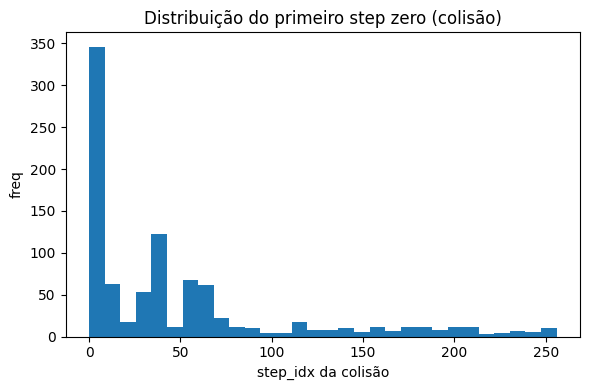

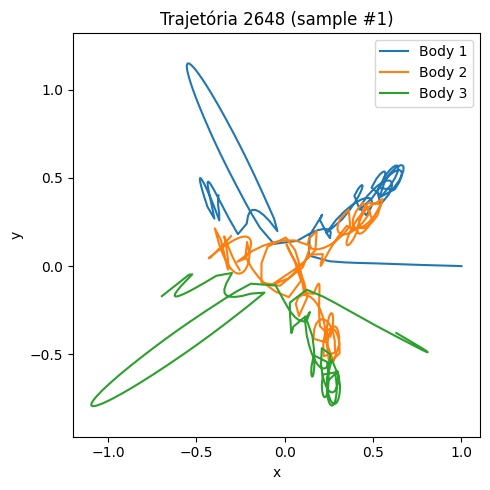

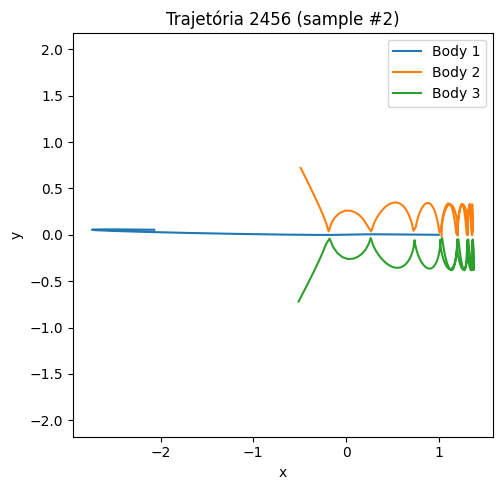

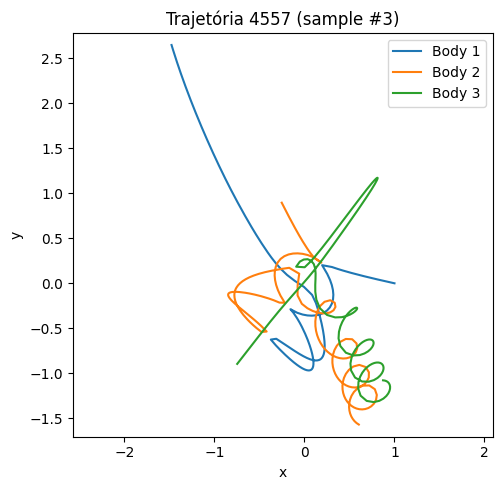

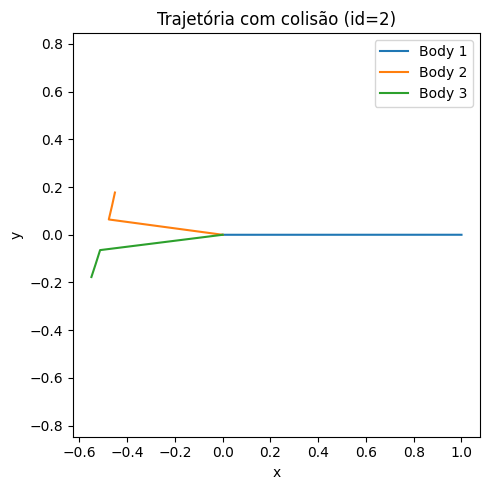

In [25]:
# Histograma do primeiro step zero (colisão)
if n_collide > 0:
    plt.figure(figsize=(6,4))
    first_zero.dropna().astype(int).plot(kind='hist', bins=30)
    plt.title('Distribuição do primeiro step zero (colisão)')
    plt.xlabel('step_idx da colisão')
    plt.ylabel('freq')
    plt.tight_layout()
    plt.show()
else:
    print('Sem colisões detetadas para o histograma.')

# 3 trajetórias aleatórias
np.random.seed(SEED)
all_traj = train['traj_idx'].unique()
sample_trajs = np.random.choice(all_traj, size=min(3, len(all_traj)), replace=False)

for i, ti in enumerate(sample_trajs, start=1):
    g = train[train['traj_idx']==ti].sort_values('step_idx')
    plt.figure(figsize=(5,5))
    plt.plot(g['x_1'], g['y_1'], label='Body 1')
    plt.plot(g['x_2'], g['y_2'], label='Body 2')
    plt.plot(g['x_3'], g['y_3'], label='Body 3')
    plt.title(f'Trajetória {ti} (sample #{i})')
    plt.xlabel('x'); plt.ylabel('y'); plt.axis('equal'); plt.legend()
    plt.tight_layout()
    plt.show()

# Uma trajetória com colisão (se existir)
if n_collide > 0:
    collide_tid = first_zero.dropna().index[0]
    g = train[train['traj_idx']==collide_tid].sort_values('step_idx')
    plt.figure(figsize=(5,5))
    plt.plot(g['x_1'], g['y_1'], label='Body 1')
    plt.plot(g['x_2'], g['y_2'], label='Body 2')
    plt.plot(g['x_3'], g['y_3'], label='Body 3')
    plt.title(f'Trajetória com colisão (id={collide_tid})')
    plt.xlabel('x'); plt.ylabel('y'); plt.axis('equal'); plt.legend()
    plt.tight_layout()
    plt.show()

## Task 1.2 — Baseline: StandardScaler + LinearRegression

In [26]:
# Split 70/15/15 por trajetória (sem vazamento)
traj_ids = np.array(sorted(train_valid['traj_idx'].unique()))
n_traj = len(traj_ids)
traj_train, traj_temp = train_test_split(traj_ids, test_size=(SPLIT_VAL + SPLIT_TEST), random_state=SEED, shuffle=True)
traj_val, traj_test   = train_test_split(traj_temp, test_size=(SPLIT_TEST/(SPLIT_VAL+SPLIT_TEST)), random_state=SEED, shuffle=True)

def subset_by_trajs(df, trajs): return df[df['traj_idx'].isin(trajs)]

df_tr = subset_by_trajs(train_valid, traj_train)
df_va = subset_by_trajs(train_valid, traj_val)
df_te = subset_by_trajs(train_valid, traj_test)

print('Traj counts -> train/val/test:', len(traj_train), len(traj_val), len(traj_test))
print('Proporções (traj):', 
      round(len(traj_train)/n_traj,3), 
      round(len(traj_val)/n_traj,3), 
      round(len(traj_test)/n_traj,3))

# Prova de não-sobreposição das condições iniciais
def initial_tuple(df):
    starts = df[df['step_idx']==0][['x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']].copy()
    starts['key'] = list(map(tuple, starts.values))
    return set(starts['key'].tolist())

init_tr = initial_tuple(df_tr); init_va = initial_tuple(df_va); init_te = initial_tuple(df_te)
overlap_any = (init_tr & init_va) | (init_tr & init_te) | (init_va & init_te)
print('Sobreposição de condições iniciais entre conjuntos? ->', 'SIM' if len(overlap_any)>0 else 'NÃO')

Traj counts -> train/val/test: 3498 750 750
Proporções (traj): 0.7 0.15 0.15
Sobreposição de condições iniciais entre conjuntos? -> NÃO


In [27]:
# Matrices
feature_cols = ['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']
target_cols  = ['x_1','y_1','x_2','y_2','x_3','y_3']

X_tr = df_tr[feature_cols].values
y_tr = df_tr[target_cols].values
X_va = df_va[feature_cols].values
y_va = df_va[target_cols].values
X_te_local = df_te[feature_cols].values
y_te_local = df_te[target_cols].values

# Baseline pipeline
baseline = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
baseline.fit(X_tr, y_tr)

y_pred_tr = baseline.predict(X_tr)
y_pred_va = baseline.predict(X_va)
y_pred_te = baseline.predict(X_te_local)

rmse_tr = np.sqrt(mean_squared_error(y_tr, y_pred_tr))
rmse_va = np.sqrt(mean_squared_error(y_va, y_pred_va))
rmse_te = np.sqrt(mean_squared_error(y_te_local, y_pred_te))

print(f'RMSE treino:      {rmse_tr:.6f}')
print(f'RMSE validação:   {rmse_va:.6f}')
print(f'RMSE teste local: {rmse_te:.6f}')

RMSE treino:      1.436633
RMSE validação:   1.280686
RMSE teste local: 1.348317


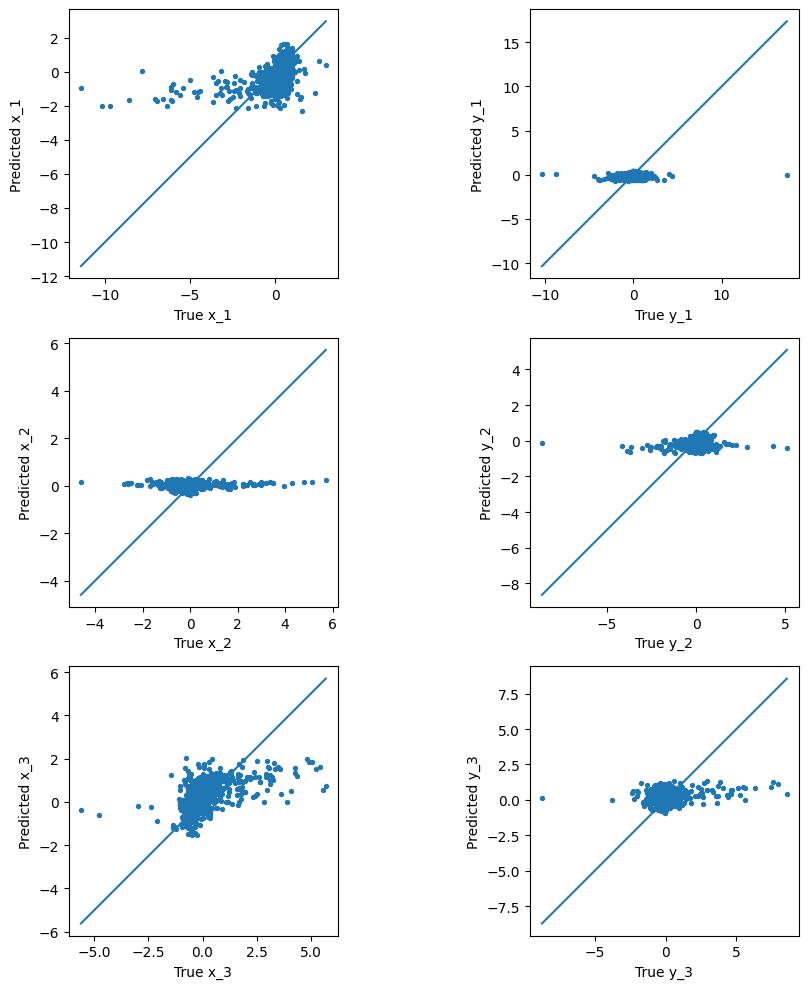

In [28]:
# y–ŷ plot (validação) inline
def plot_y_yhat_inline(y_test, y_pred):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    idx = np.random.choice(len(y_test), min(MAX, len(y_test)), replace=False)
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i]); x1 = np.max(y_test[idx,i])
        ax = plt.subplot(3,2,i+1)
        ax.scatter(y_test[idx,i], y_pred[idx,i], s=8)
        ax.plot([x0,x1],[x0,x1])
        ax.set_xlabel('True '+labels[i]); ax.set_ylabel('Predicted '+labels[i])
        ax.set_aspect('equal','box')
    plt.tight_layout()
    plt.show()

plot_y_yhat_inline(y_va, y_pred_va)

### Submissão Kaggle — `baseline-model.csv` (treino em train+val)

In [29]:
X_tr_full = pd.concat([df_tr[feature_cols], df_va[feature_cols]], axis=0).values
y_tr_full = pd.concat([df_tr[target_cols],  df_va[target_cols]],  axis=0).values

baseline_full = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())]).fit(X_tr_full, y_tr_full)

X_submit = test[['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']].values
y_submit = baseline_full.predict(X_submit)

submission = pd.DataFrame({
    'Id': test['Id'],
    'x_1': y_submit[:,0],
    'y_1': y_submit[:,1],
    'x_2': y_submit[:,2],
    'y_2': y_submit[:,3],
    'x_3': y_submit[:,4],
    'y_3': y_submit[:,5],
})
submission.to_csv('../outputs/baseline-model.csv', index=False)
print('Wrote baseline-model.csv')

Wrote baseline-model.csv


## Task 2.1 — Polynomial Regression Validation

In [30]:
def validate_poly_regression(X_train, y_train, X_val, y_val, 
                             regressor=None, 
                             degrees=range(1,15), 
                             subset_frac=None, 
                             random_state=None):
    """Valida regressão polinomial para vários graus e retorna o melhor pipeline e RMSE."
    """
    if regressor is None or regressor == 'linear':
        reg = LinearRegression()
    elif regressor == 'ridge':
        reg = RidgeCV(alphas=np.logspace(-4, 4, 13))
    else:
        reg = regressor
    
    # Optional subsample for speed
    if subset_frac is not None and 0 < subset_frac < 1.0:
        n_sub = max(1000, int(len(X_train) * subset_frac))
        rng = np.random.RandomState(random_state)
        idx = rng.choice(len(X_train), size=n_sub, replace=False)
        X_tr = X_train[idx]
        y_tr = y_train[idx]
    else:
        X_tr, y_tr = X_train, y_train
    
    best_rmse = np.inf
    best_model = None
    rmse_by_d = []
    feats_by_d = []
    results = {}
    
    for d in degrees:
        poly = PolynomialFeatures(degree=d, include_bias=False)
        pipe = Pipeline([('poly', poly), ('scaler', StandardScaler()), ('reg', reg)])
        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        n_out_feats = pipe.named_steps['poly'].n_output_features_
        results[d] = {'rmse': rmse, 'n_features': n_out_feats}
        rmse_by_d.append(rmse)
        feats_by_d.append(n_out_feats)
        print(f"grau={d:2d} | n_features={n_out_feats:5d} | RMSE_val={rmse:.6f}")
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = pipe
    
    # Plot inline: RMSE vs degree and number of features (twin axis)
    fig, ax1 = plt.subplots(figsize=(7,4))
    ax1.plot(list(degrees), rmse_by_d, marker='o')
    ax1.set_xlabel('Grau polinomial')
    ax1.set_ylabel('RMSE (validação)')
    ax2 = ax1.twinx()
    ax2.plot(list(degrees), feats_by_d, marker='x')
    ax2.set_ylabel('Nº de features')
    plt.title('RMSE vs Grau (linha) e Nº de Features (cruzes)')
    plt.tight_layout()
    plt.show()
    
    return best_model, best_rmse, results

### Run: LinearRegression

grau= 1 | n_features=    7 | RMSE_val=1.280694
grau= 2 | n_features=   35 | RMSE_val=1.248610
grau= 3 | n_features=  119 | RMSE_val=1.209269
grau= 4 | n_features=  329 | RMSE_val=1.167819
grau= 5 | n_features=  791 | RMSE_val=1.139528
grau= 6 | n_features= 1715 | RMSE_val=1.121210
grau= 7 | n_features= 3431 | RMSE_val=1.102943


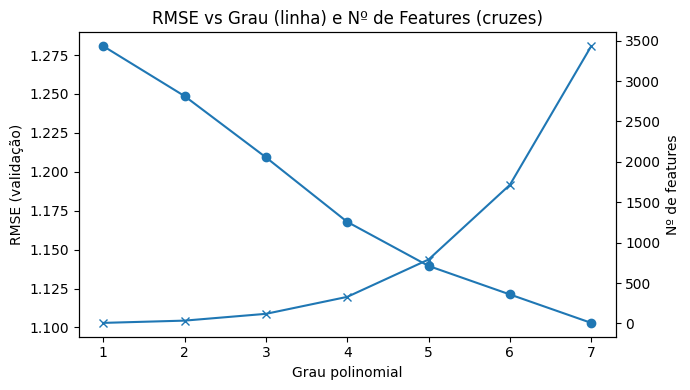


Melhor (Linear): RMSE_val = 1.1029434219065273


In [31]:
best_lin_model, best_lin_rmse, lin_results = validate_poly_regression(
    X_tr, y_tr, X_va, y_va,
    regressor='linear',
    degrees=range(1,8),
    subset_frac=0.05,
    random_state=SEED
)
print('\nMelhor (Linear): RMSE_val =', best_lin_rmse)

### Run: RidgeCV

grau= 1 | n_features=    7 | RMSE_val=1.280691
grau= 2 | n_features=   35 | RMSE_val=1.248594
grau= 3 | n_features=  119 | RMSE_val=1.209250
grau= 4 | n_features=  329 | RMSE_val=1.167841
grau= 5 | n_features=  791 | RMSE_val=1.139333
grau= 6 | n_features= 1715 | RMSE_val=1.120749
grau= 7 | n_features= 3431 | RMSE_val=1.102882


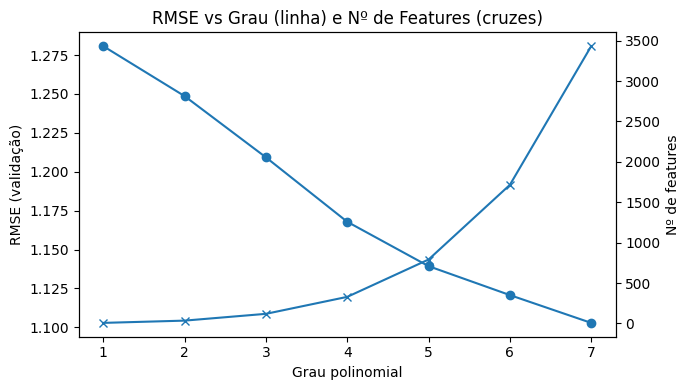


Melhor (RidgeCV): RMSE_val = 1.102881815094003


In [32]:
best_ridge_model, best_ridge_rmse, ridge_results = validate_poly_regression(
    X_tr, y_tr, X_va, y_va,
    regressor='ridge',
    degrees=range(1,8),
    subset_frac=0.05,
    random_state=SEED
)
print('\nMelhor (RidgeCV): RMSE_val =', best_ridge_rmse)

### 10 execuções (distribuição do grau ótimo)

In [ ]:
def run_many(n_runs=10, regressor='ridge', subset_frac=0.10, degrees=range(1,15)):
    best_degrees = []
    best_rmses   = []
    for i in range(n_runs):
        seed_i = SEED + i
        model, rmse, res = validate_poly_regression(
            X_tr, y_tr, X_va, y_va,
            regressor=regressor,
            degrees=degrees,
            subset_frac=subset_frac,
            random_state=seed_i
        )
        d_best = min(res.keys(), key=lambda d: res[d]['rmse'])
        best_degrees.append(d_best)
        best_rmses.append(rmse)
        print(f"[Run {i+1:02d}] Best degree = {d_best} | RMSE_val = {rmse:.6f}")
    return np.array(best_degrees), np.array(best_rmses)

best_deg_ridge, best_rmse_ridge = run_many(n_runs=10, regressor='ridge', subset_frac=0.10)

plt.figure(figsize=(6,4))
plt.hist(best_deg_ridge, bins=np.arange(0.5,14.6,1), rwidth=0.85)
plt.xticks(range(1,15))
plt.xlabel('Grau selecionado (RidgeCV)')
plt.ylabel('Frequência em 10 execuções')
plt.title('Distribuição do grau ótimo (amostra 10 execuções)')
plt.tight_layout()
plt.show()

print('Graus escolhidos (RidgeCV):', best_deg_ridge.tolist())
print('Mais frequente:', int(pd.Series(best_deg_ridge).mode().iloc[0]))

## Task 2.2 — Evaluation (Polynomial vs Baseline)
- Treinar **modelo polinomial final** (grau ótimo) em **train+val**.
- Comparar RMSE local e **y–ŷ** vs baseline.
- Gerar **`polynomial_submission.csv`** para Kaggle (único ficheiro gravado).

In [33]:

try:
    BEST_DEGREE = 5
except Exception:
    try:
        BEST_DEGREE = min(ridge_results.keys(), key=lambda d: ridge_results[d]['rmse'])
    except Exception:
        try:
            BEST_DEGREE = min(lin_results.keys(), key=lambda d: lin_results[d]['rmse'])
        except Exception:
            BEST_DEGREE = 3
print('BEST_DEGREE =', BEST_DEGREE)

REGRESSOR = 'ridge'  # altera para 'linear' se quiseres
print('REGRESSOR   =', REGRESSOR)

BEST_DEGREE = 5
REGRESSOR   = ridge


In [34]:
# Treino final em (train + val)

X_train_full = pd.concat([df_tr[feature_cols], df_va[feature_cols]], axis=0).values
y_train_full = pd.concat([df_tr[target_cols],  df_va[target_cols]],  axis=0).values

reg = LinearRegression() if REGRESSOR=='linear' else RidgeCV(alphas=np.logspace(-4,4,13))

poly_final = Pipeline([
    ('poly',   PolynomialFeatures(degree=int(BEST_DEGREE), include_bias=False)),
    ('scaler', StandardScaler()),
    ('reg',    reg)
])

poly_final.fit(X_train_full, y_train_full)

# Avaliação no teste local
y_pred_test_local = poly_final.predict(X_te_local)
rmse_test_local = np.sqrt(mean_squared_error(y_te_local, y_pred_test_local))
print(f'RMSE teste local (polynomial, grau={BEST_DEGREE}, {REGRESSOR}): {rmse_test_local:.6f}')

RMSE teste local (polynomial, grau=5, ridge): 1.174641


In [38]:
# Comparação com o baseline
try:
    y_pred_test_baseline = baseline.predict(X_te_local)
    rmse_test_baseline   = np.sqrt(mean_squared_error(y_te_local, y_pred_test_baseline))
    print(f'RMSE teste local (baseline): {rmse_test_baseline:.6f}')
    print(f'Diferença ΔRMSE (baseline - poly): {rmse_test_baseline - rmse_test_local:.6f}  (positivo = poly melhor)')
except NameError:
    print('Baseline não está disponível nesta sessão.')

RMSE teste local (baseline): 1.348317
Diferença ΔRMSE (baseline - poly): 0.173676  (positivo = poly melhor)


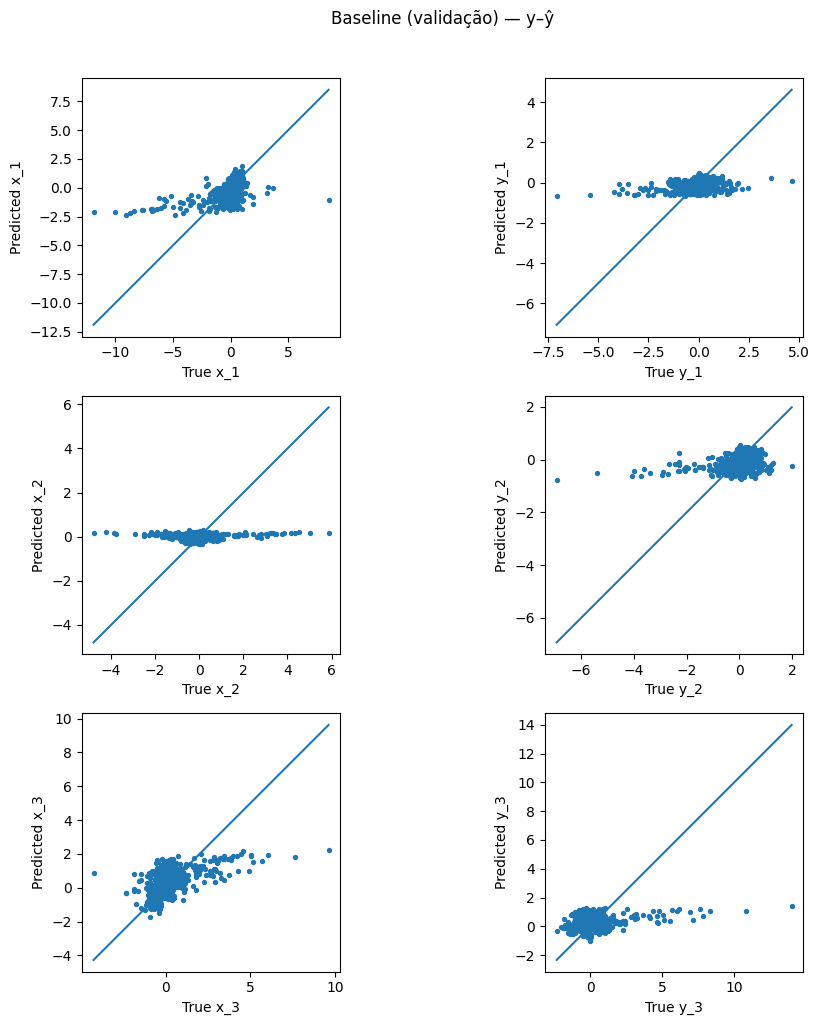

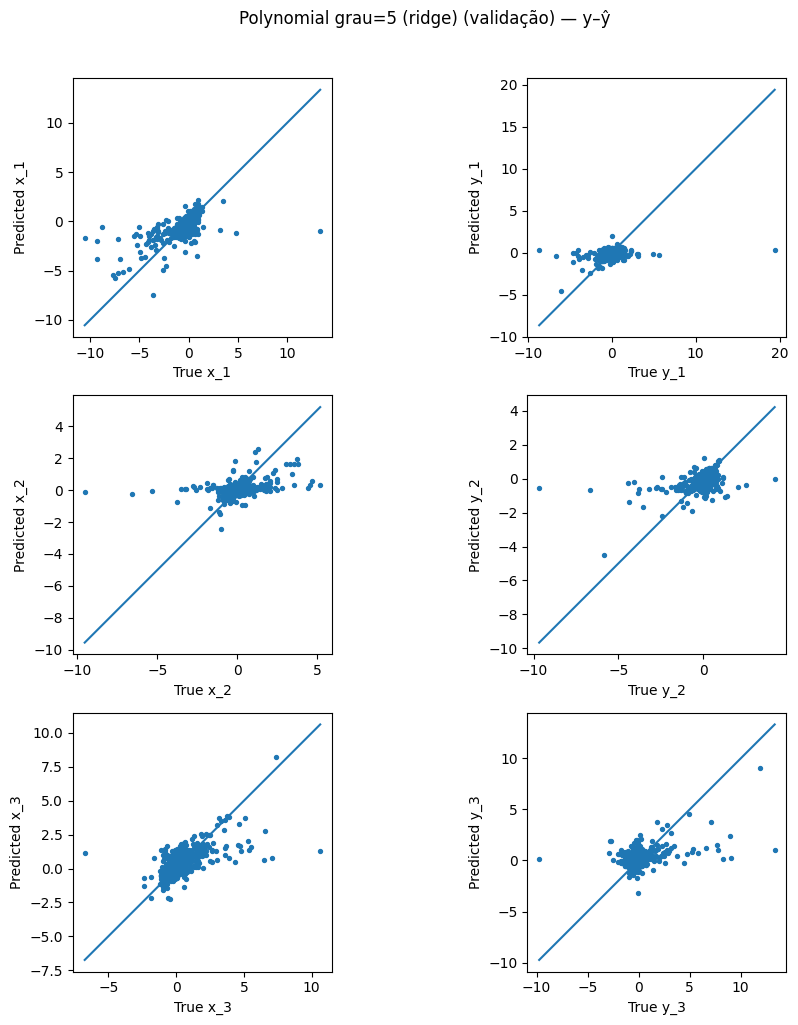

In [39]:
# y–ŷ plots (validação) inline
def plot_y_yhat_inline_named(y_true, y_pred, title):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    idx = np.random.choice(len(y_true), min(MAX, len(y_true)), replace=False)
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_true[idx,i]); x1 = np.max(y_true[idx,i])
        ax = plt.subplot(3,2,i+1)
        ax.scatter(y_true[idx,i], y_pred[idx,i], s=8)
        ax.plot([x0,x1],[x0,x1])
        ax.set_xlabel('True '+labels[i]); ax.set_ylabel('Predicted '+labels[i])
        ax.set_aspect('equal','box')
    plt.suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# baseline
try:
    y_pred_va_baseline = baseline.predict(X_va)
    plot_y_yhat_inline_named(y_va, y_pred_va_baseline, 'Baseline (validação) — y–ŷ')
except NameError:
    print('Baseline não está disponível nesta sessão.')

# polynomial
y_pred_va_poly = poly_final.predict(X_va)
plot_y_yhat_inline_named(y_va, y_pred_va_poly, f'Polynomial grau={BEST_DEGREE} ({REGRESSOR}) (validação) — y–ŷ')

In [40]:
# Submissão Kaggle: polynomial_submission.csv
X_submit = test[['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']].values
y_submit = poly_final.predict(X_submit)

polynomial_submission = pd.DataFrame({
    'Id': test['Id'],
    'x_1': y_submit[:,0],
    'y_1': y_submit[:,1],
    'x_2': y_submit[:,2],
    'y_2': y_submit[:,3],
    'x_3': y_submit[:,4],
    'y_3': y_submit[:,5],
})
polynomial_submission.to_csv('../outputs/polynomial_submission.csv', index=False)
print('Wrote polynomial_submission.csv')

Wrote polynomial_submission.csv
